#Proyecto: Análisis del comportamiento del consumidor para adquirir seguros

### Nancy Pérez Reyes ###

Este proyecto está basado en el dataset *Bank Marketing Campaign Dataset* disponible en la plataforma [Kaggle](https://www.kaggle.com/datasets/yaminh/bank-marketing-campaign-dataset). Las principales columnas del dataset son:

1.**age_group** : el grupo de edad del cliente.

2.**ocupación** : la ocupación del cliente.

3.**marital_status** : el estado civil del cliente.

4.**education_level** : el nivel educativo más alto alcanzado por el cliente.

5.**canal_comunicación** : el canal de comunicación utilizado para contactar al cliente.

6.**call_day** : el día del mes en el que se realizó la llamada.

7.**call_month** : el mes del año en el que se realizó la llamada.

8.**call_duration** : la duración de la llamada en segundos.

9.**call_frequency** : la frecuencia de las llamadas realizadas al cliente.

10.**anterior_campaign_outcome** : el resultado de la campaña de marketing anterior para el cliente.



Cada fila representa un registro de interacción con el cliente, que detalla varios atributos como edad, ocupación, estado civil, nivel educativo, canal de comunicación, momento y duración de las llamadas, resultado de campañas anteriores y estado de conversión. Este conjunto de datos se puede utilizar para analizar el comportamiento de los clientes, predecir tasas de conversión y optimizar estrategias de marketing en la industria de seguros.


### Objetivos y tareas



*   Realizar un análisis exploratorio de los datos para obtener estadísticas sobre los datos obtenidos.

*   Conectar el dataset con *Python* sobre colab para realizar predicciones y clasificaciones.

*   Encontrar el tipo de modelo mejor posible para predecir el comportamiento del consumidor para adquirir un seguro.










##Análisis exploratorio de datos







In [ ]:
#Importe de las librerías
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as forest
from sklearn import metrics
import numpy as np
from sklearn import tree as treeClassifier

In [ ]:
#Lectura del dataset
df_seguro = pd.read_csv('/content/dataset.csv')
df_seguro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   occupation                 45211 non-null  object
 1   age                        45211 non-null  int64 
 2   education_level            45211 non-null  object
 3   marital_status             45211 non-null  object
 4   communication_channel      45211 non-null  object
 5   call_month                 45211 non-null  object
 6   call_day                   45211 non-null  int64 
 7   call_duration              45211 non-null  int64 
 8   call_frequency             45211 non-null  int64 
 9   previous_campaign_outcome  45211 non-null  object
 10  conversion_status          45211 non-null  object
dtypes: int64(4), object(7)
memory usage: 3.8+ MB


In [ ]:
#Columnas del dtaframe
df_seguro.columns

Index(['occupation', 'age', 'education_level', 'marital_status',
       'communication_channel', 'call_month', 'call_day', 'call_duration',
       'call_frequency', 'previous_campaign_outcome', 'conversion_status'],
      dtype='object')

In [ ]:
#Datos estadísticos de la edad
df_seguro.age.describe()

count    45211.000000
mean        40.936210
std         10.618762
min         18.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

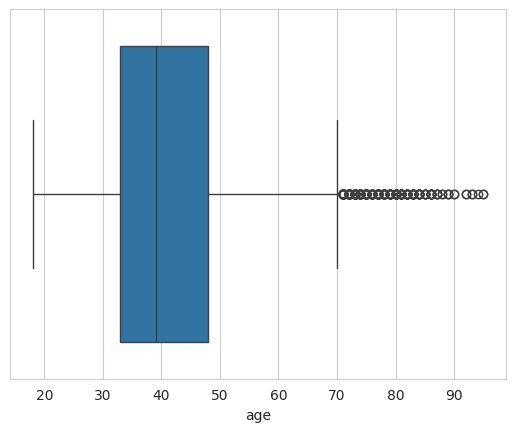

In [ ]:
#Diagrama de caja
sns.set_style("whitegrid")
sns.boxplot(x=df_seguro['age']);

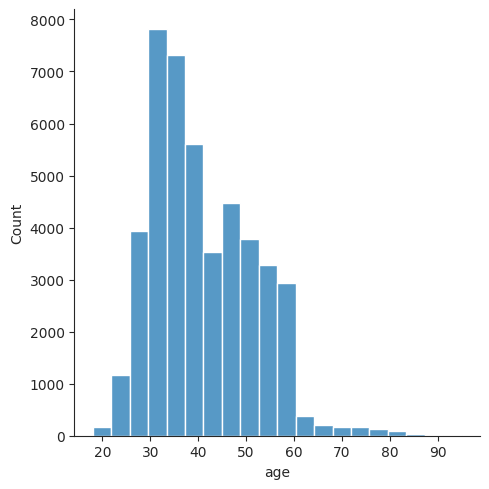

In [ ]:

# Histograma
sns.set_style('ticks')
sns.displot(df_seguro['age'], kde=False, bins=20);

In [ ]:
df_seguro.mode().head(1)[['occupation','age','education_level','marital_status','communication_channel','previous_campaign_outcome','conversion_status']]

,occupation,age,education_level,marital_status,communication_channel,previous_campaign_outcome,conversion_status
0,manual_worker,32,high_school,married,mobile,unidentified,not_converted


In [ ]:
df_seguro.mode().head(1)[['communication_channel', 'call_month', 'call_day', 'call_duration',
       'call_frequency']]

,communication_channel,call_month,call_day,call_duration,call_frequency
0,mobile,May,20,124,1


Dos variables se presentan desde luego el perfil del consumidor, al igual que los esfuerzos de comunicación (laspsos de tiempo) en las campañas digitales para la promoción de seguros

In [ ]:
#Crosstab sobre los perfiles del consumidor
crosstab1 = pd.crosstab(df_seguro['conversion_status'],[df_seguro['occupation'],df_seguro['age'],df_seguro['education_level'], df_seguro['marital_status']],margins=True,margins_name='total')
crosstab1

occupation        administrative_staff                                   \
age                                 20      21                            
education_level            high_school college high_school unidentified   
marital_status                  single  single      single       single   
conversion_status                                                         
converted                            0       0           1            0   
not_converted                        2       1           2            1   
total                                2       1           3            1   

occupation                                                               ...  \
age                    22                         23                     ...   
education_level   college high_school        college        high_school  ...   
marital_status     single     married single married single     married  ...   
conversion_status                                                        ...   
converted               1           0      3       0      2           0  ...   
not_converted           2           1      7       1      2           3  ...   
total                   3           1     10       1      4           3  ...   

occupation        unidentified                                            \
age                         67           68      70      71           72   
education_level        college unidentified college college unidentified   
marital_status         married      married married married      married   
conversion_status                                                          
converted                    0            0       0       0            0   
not_converted                1            1       1       1            1   
total                        1            1       1       1            1   

occupation                                                        total  
age                    75           77           78           82         
education_level   college unidentified unidentified unidentified         
marital_status    married      married      married     divorced         
conversion_status                                                        
converted               0            1            1            0   5289  
not_converted           1            1            0            1  39922  
total                   1            2            1            1  45211  

[3 rows x 3638 columns]

Los datos anteriores nos muestran que tan solo el 12% de está muestra dio clic en algún anuncio con el tema de seguros. Dada la calidad de los datos de los campos ocupación, edad, educación, estado civil no se puede interpretar correctamente para identificar un perfil ideal del consumidor, es necesario limpiar y transformar los datos.

In [ ]:
df_seguro.mode().head(1)[['occupation','age','education_level','marital_status','communication_channel','previous_campaign_outcome','conversion_status']]

,occupation,age,education_level,marital_status,communication_channel,previous_campaign_outcome,conversion_status
0,manual_worker,32,high_school,married,mobile,unidentified,not_converted


In [ ]:
#Crosstab de esfuerzos de comunicación (lapsos de tiempo)
crosstab2 = pd.crosstab(df_seguro['communication_channel'],[df_seguro['call_month'],df_seguro['call_day'],df_seguro['call_duration'], df_seguro['call_frequency']],margins=True,margins_name='total')
crosstab2

call_month            April                                     ... September  \
call_day                  1                                     ...        30   
call_duration            73 74 107 111 117 121 124 126 131 149  ...       117   
call_frequency            1  3   1   1   1   2   1   2   1   1  ...         1   
communication_channel                                           ...             
landline                  0  1   0   0   0   0   0   0   0   0  ...         0   
mobile                    1  0   1   0   1   1   1   1   1   1  ...         1   
unidentified              0  0   0   1   0   0   0   0   0   0  ...         0   
total                     1  1   1   1   1   1   1   1   1   1  ...         1   

call_month                                             total  
call_day                                                      
call_duration         134 175 195 234 314 431 585 992         
call_frequency          1   1   1   1   1   1   1   2         
communication_channel                                         
landline                0   0   0   1   0   1   0   1   2906  
mobile                  1   0   1   0   1   0   1   0  29285  
unidentified            0   1   0   0   0   0   0   0  13020  
total                   1   1   1   1   1   1   1   1  45211  

[4 rows x 39604 columns]

###Los esfuerzos de comunicación dentro de las campañas han sido más efectivas si son reproducidas en dispositivos móviles.


#Análisis de regresión

In [69]:
df_seguro


,occupation,age,education_level,marital_status,communication_channel,call_month,call_day,call_duration,call_frequency,previous_campaign_outcome,conversion_status
0,administrative_staff,28,high_school,married,unidentified,September,9,1,1,successful,not_converted
1,administrative_staff,58,unidentified,married,unidentified,June,5,307,2,unidentified,not_converted
2,jobless,40,high_school,divorced,mobile,February,4,113,1,unidentified,not_converted
3,retired_worker,63,high_school,married,mobile,April,7,72,5,unidentified,not_converted
4,business_owner,43,college,married,landline,July,29,184,4,unidentified,not_converted
...,...,...,...,...,...,...,...,...,...,...,...
45206,administrative_staff,50,high_school,divorced,mobile,May,6,114,1,unsuccessful,not_converted
45207,independent_worker,49,college,married,unidentified,May,13,98,1,unidentified,not_converted
45208,executive,30,college,married,mobile,June,12,175,2,other_outcome,not_converted
45209,retired_worker,59,elementary_school,married,landline,July,15,41,5,unidentified,not_converted


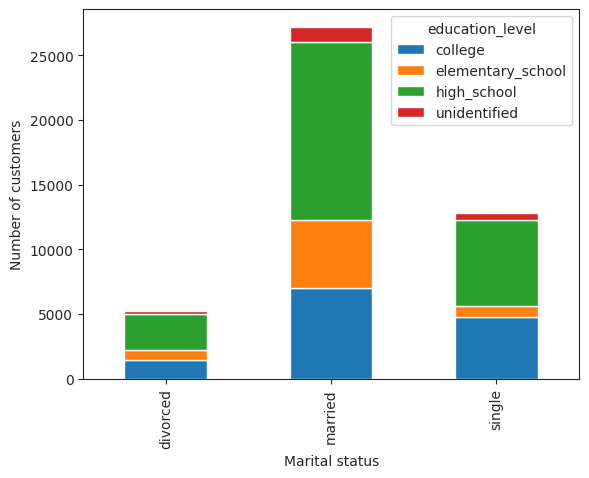

In [75]:
# @title Education level by marital status

import matplotlib.pyplot as plt
df_seguro.groupby(['marital_status', 'education_level']).size().unstack().plot(kind='bar', stacked=True)
plt.xlabel('Marital status')
_ = plt.ylabel('Number of customers')

<Axes: xlabel='conversion_status'>

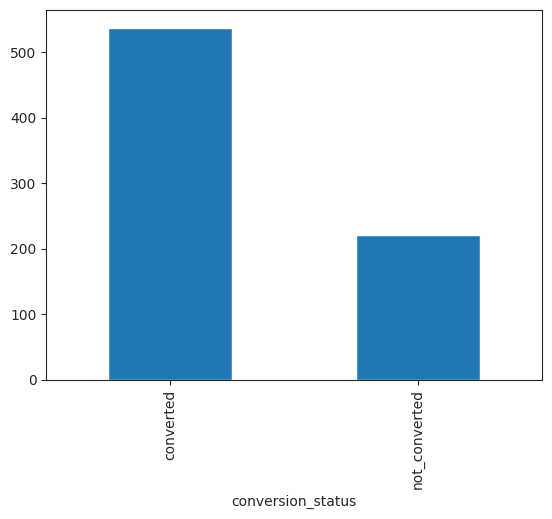

In [74]:
# @title Average call duration by conversion status

df_seguro.groupby('conversion_status')['call_duration'].mean().plot(kind='bar')

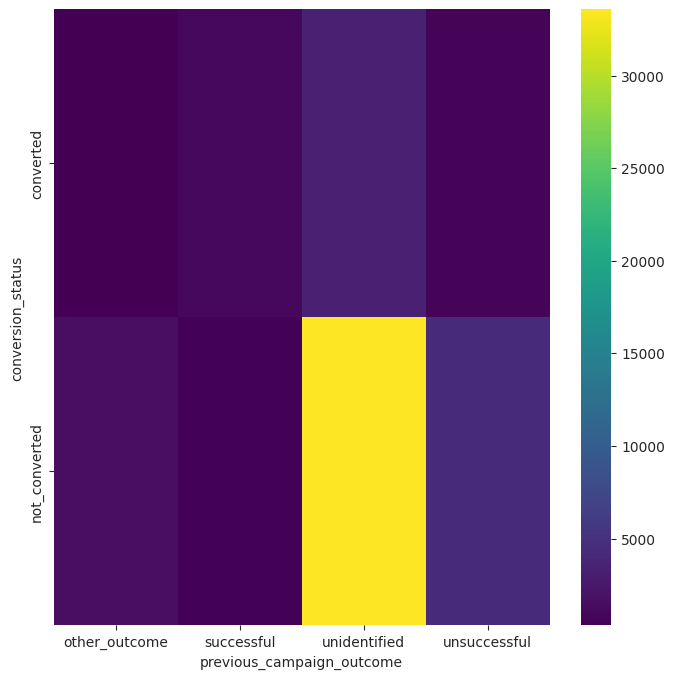

In [73]:
# @title previous_campaign_outcome vs conversion_status

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['conversion_status'].value_counts()
    for x_label, grp in df_seguro.groupby('previous_campaign_outcome')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('previous_campaign_outcome')
_ = plt.ylabel('conversion_status')

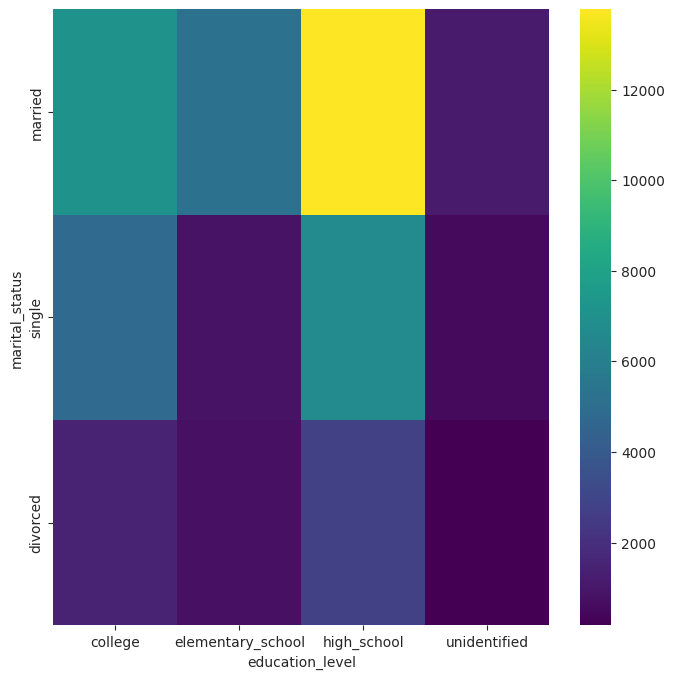

In [71]:
# @title education_level vs marital_status

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['marital_status'].value_counts()
    for x_label, grp in df_seguro.groupby('education_level')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('education_level')
_ = plt.ylabel('marital_status')

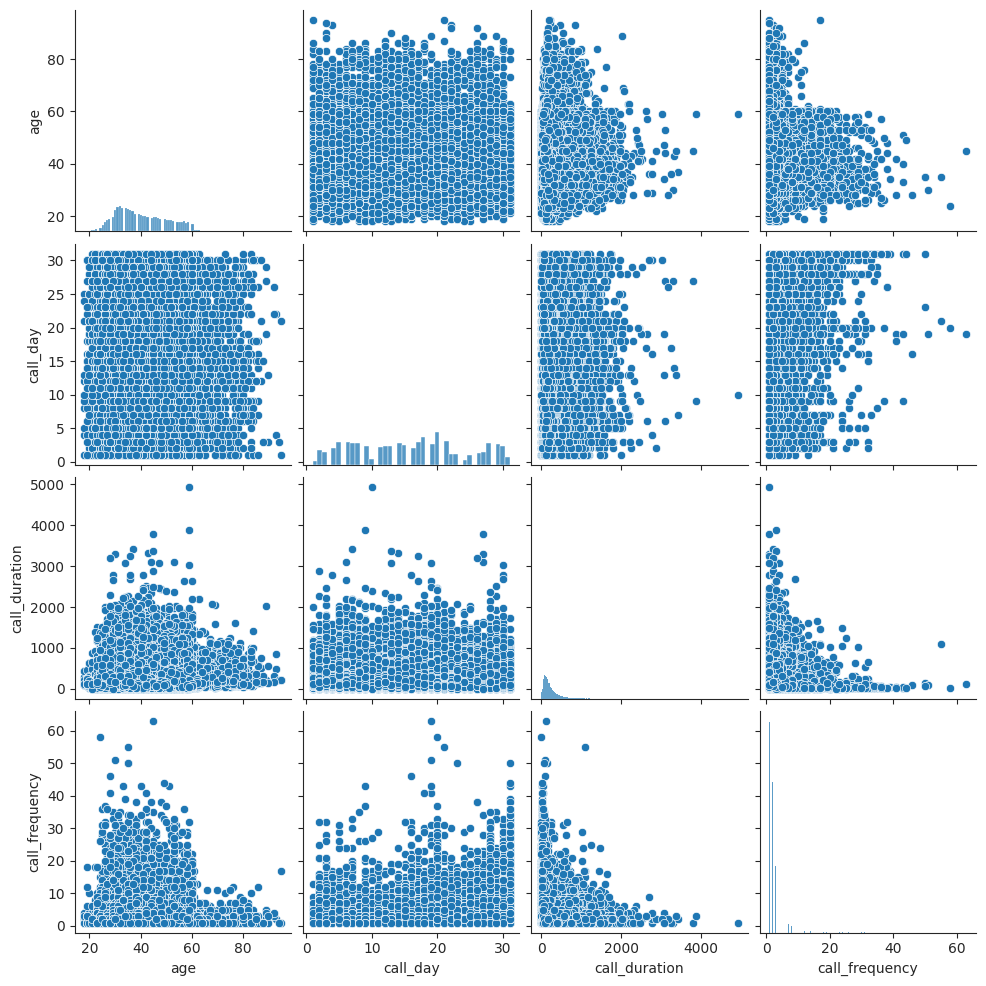

In [70]:
sns.pairplot(df_seguro)

#Matriz de confusión
###No se pudo completar debido a qué los datos no se unificaron en 0 y 1 para su lectura. El campo "Conversión de estatus" es de tipo texto.

In [96]:
X = df_seguro.drop(columns=['occupation',	'age',	'education_level',	'marital_status',	'communication_channel','call_month','previous_campaign_outcome'])
y = df_seguro['conversion_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [98]:
bosque = forest(n_estimators = 800)
bosque.fit(X_train, y_train)

#Conclusiones


*   Las personas interesadas en adquirir algún seguro rondan entre las edades de los 33 a los 48 años.

*   De los cuales están casados, tienen un empleo cómo ejecutivos y un nivel educativo medio superior.

*   La mejor manera de tener una alcance en campañas digitales es generar anuncios para dispositivos moviles.

*   Los esfuerzos en publicidad deben considerar el perfil anteriormente descrito para asegurar la conversión (clics, compras, compartidos, comentados, etc.)


*   Unificar los datos tipo texto y númericos para completar los mejores modelos posibles.





#Trabajo a futuro

*  Integrar todos los datos para crear mejores modelos de predicción y clasificacíón que aseguren el perfil y comportamiento de compra.

*  Recabar nuevos datos sociodemograficos para perfilar mejor el segmento de compra.

*  Recabar información sobre los mensajes qué se promociones acerca de los seguros para ver su eficación por palabras claves.